<a href="https://colab.research.google.com/github/xyzkpsf/CS-W182-CV-Project/blob/main/Effici_Adv_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install efficientnet_pytorch
!pip install -q torchbearer
!pip install adversarial-robustness-toolbox
!pip install livelossplot
from efficientnet_pytorch import EfficientNet
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import PyTorchClassifier
import torchbearer

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
import pandas as pd
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from torchvision.io import read_image
from skimage import io, transform
from PIL import Image
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
import time
import copy
import os
import sys


In [ ]:
!unzip '/content/drive/MyDrive/Spring 2021/CS 182/tiny-imagenet-200.zip'

In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, val_label_dir, img_dir, train_path, transform=None, target_transform=None):
        super(CustomImageDataset, self).__init__()
        self.val_label_file = pd.read_csv(val_label_dir, delimiter = "\t", names=["pics", "labels", "_1", "_2", "_3", "_4"])
        self.img_labels = self.val_label_file[["pics", 'labels']]
        self.img_dir = img_dir
        self.transform = transform
        self.classes, self.class_to_idx = self._find_classes(train_path)

    def __len__(self):
        return len(self.img_labels)

    def _find_classes(self, dir):
        """
        Finds the class folders in a dataset.
        Args:
            dir (string): Root directory path.
        Returns:
            tuple: (classes, class_to_idx) where classes are relative to (dir), and class_to_idx is a dictionary.
        Ensures:
            No class is a subdirectory of another.
        """
        if sys.version_info >= (3, 5):
            # Faster and available in Python 3.5 and above
            classes = [d.name for d in os.scandir(dir) if d.is_dir()]
        else:
            classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
        classes.sort()
        class_to_idx = {classes[i]: i for i in range(len(classes))}
        return classes, class_to_idx

    def pad(self, img):
        padding = np.ones((64, 64, 2))
        img = img.reshape((64, 64, 1))
        img = np.concatenate((img, padding), axis=2)
        return img.astype(np.float32)
      
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        img = Image.open(img_path)
        img = copy.deepcopy(np.asarray(img))
        # if it has less than 3 channels
        if img.shape != (64, 64, 3):
            img = self.pad(img)
        #print(img.shape)
        label = self.img_labels.iloc[idx, 1]
        label = self.class_to_idx[label]
        if self.transform:
            img = self.transform(img)
        #sample = {"image": img, "label": label}
        return img, label

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/tiny-imagenet-200'

val_label_dir = '/content/tiny-imagenet-200/val/val_annotations.txt'

image_datasets = {}

image_datasets['train'] = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                          data_transforms['train'])

image_datasets['val'] = CustomImageDataset(val_label_dir, data_dir+'/val/images', 
                                           os.path.join(data_dir, 'train'),
                                           transform=data_transforms['val'])

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128,
                                             shuffle=False, num_workers=2)
                                            for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [21]:
#Efficient Net
model = EfficientNet.from_pretrained('efficientnet-b0')


Loaded pretrained weights for efficientnet-b0


In [ ]:
model

In [6]:
def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=30):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    since = time.time()
    liveloss = PlotLosses()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i,(inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                print("\rIteration: {}/{}, Loss: {}.".format(i+1, len(dataloaders[phase]), loss.item() * inputs.size(0)), end="")
                sys.stdout.flush()
                
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
                avg_loss = epoch_loss
                t_acc = epoch_acc
            else:
                val_loss = epoch_loss
                val_acc = epoch_acc

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        liveloss.update({
            'log loss': avg_loss,
            'val_log loss': val_loss,
            'accuracy': t_acc,
            'val_accuracy': val_acc
        })
                
        liveloss.draw()
        print('Train Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, t_acc))
        print(  'Val Loss: {:.4f} Acc: {:.4f}'.format(val_loss, val_acc))
        print('Best Val Accuracy: {}'.format(best_acc))
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [8]:
x_train = np.load("/content/drive/MyDrive/CV Project/100karray.npy")
#x_train_label = np.load("/content/drive/MyDrive/CV Project/100karray_label.npy")
#x_val = np.load("/content/drive/MyDrive/CV Project/val_100karray.npy")
#x_val_label = np.load("/content/drive/MyDrive/CV Project/val_100karray_label.npy")

In [9]:
print(x_train.shape)
#print(x_train_label.shape)
#print(x_val.shape)
#print(x_val_label.shape)

(100000, 3, 64, 64)


In [10]:
x_train_1 = x_train[:50000]
x_train_1.shape

(50000, 3, 64, 64)

In [17]:
classifier = PyTorchClassifier(
    model=model,
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 64, 64),
    nb_classes=200,
    device_type = device,
)

In [18]:
attack = FastGradientMethod(estimator=classifier, eps=0.2)

In [ ]:
x_train_adv = attack.generate(x=x_train_1)

In [ ]:
tensor_x = torch.from_numpy(np_x).float()
tensor_y = torch.from_numpy(np_y).long()


In [ ]:
np_x_val.shape
np_y_val.shape

(10000,)

In [ ]:
attack = FastGradientMethod(estimator=classifier, eps=0.2)

In [ ]:
x_val_adv = attack.generate(x=np_x_val)

In [ ]:
tensor_x_adv_val = torch.from_numpy(x_val_adv).float() # Adversarial val data
tensor_y_val = torch.from_numpy(np_y_val).long()   # Val label

In [ ]:
from torch.utils.data import TensorDataset
np_train_set = TensorDataset(tensor_x,tensor_y)
np_val_adv_set = TensorDataset(tensor_x_adv_val,tensor_y_val)

In [ ]:
new_dataloaders = {}
new_dataloaders['train'] = DataLoader(np_train_set, batch_size=128, shuffle=True, num_workers=2)
new_dataloaders['val'] = DataLoader(np_val_adv_set, batch_size=128, shuffle=True, num_workers=2)
new_dataset_sizes = {'train': len(np_train_set), 'val': len(np_val_adv_set)}

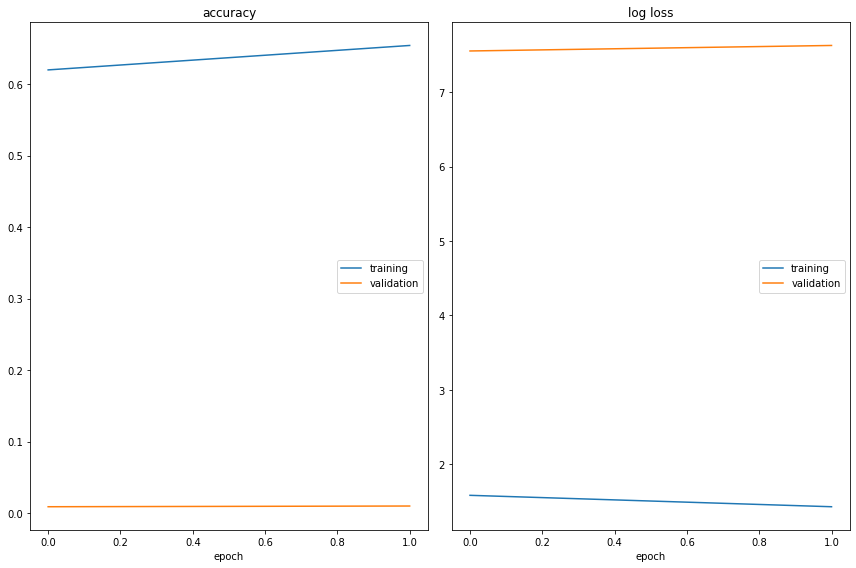

accuracy
	training         	 (min:    0.620, max:    0.654, cur:    0.654)
	validation       	 (min:    0.009, max:    0.010, cur:    0.010)
log loss
	training         	 (min:    1.428, max:    1.581, cur:    1.428)
	validation       	 (min:    7.553, max:    7.627, cur:    7.627)
Train Loss: 1.4278 Acc: 0.6541
Val Loss: 7.6268 Acc: 0.0099
Best Val Accuracy: 0.0099

Epoch 3/5
----------
Iteration: 32/782, Loss: 157.1933135986328.

KeyboardInterrupt: ignored

In [ ]:
model = train_model(model, new_dataloaders, new_dataset_sizes, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)